### Initial setup

In [1]:
import pandas as pd
import numpy as np

from sklearn.linear_model import LinearRegression
from sklearn.ensemble import RandomForestRegressor
from sklearn.linear_model import Lasso
from sklearn.linear_model import ElasticNet
from sklearn.tree import DecisionTreeRegressor
from sklearn.neighbors import KNeighborsRegressor
from sklearn.ensemble import GradientBoostingRegressor

from sklearn.model_selection import train_test_split
from sklearn.metrics import r2_score

#tuning
from sklearn.model_selection import RandomizedSearchCV

import lightgbm as lgb
import xgboost as xgb

# import warnings
# warnings.filterwarnings("ignore")

# from matplotlib import pyplot as plt

/opt/homebrew/Caskroom/miniforge/base/envs/python38/lib/python3.8/site-packages/xgboost/compat.py:36: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  from pandas import MultiIndex, Int64Index


#### Read, clean & add features

In [2]:
df = pd.read_excel("expenses.xlsx",sheet_name='Sheet 1')
# df.drop(['INDEX()'],axis=1,inplace=True)

df['Date'] = pd.to_datetime(df['Date'], format="%d.%m.%Y")

d = {'Y': 1, 'N': 0}
df['Billable Flag'] = df['Billable Flag'].map(d)

#df.drop(columns=['Department','Expense Type','Billable Flag','Number of Employees'],inplace=True)
#df = df.groupby(['Date'], as_index=False).sum()

#date part features
df['Year'] = df['Date'].dt.year
df['Month'] = df['Date'].dt.month
df['Quarter'] = df['Date'].dt.quarter
df['Day of Week'] = df['Date'].dt.dayofweek
df['Day of Month'] = df['Date'].dt.day
df['Day of Year'] = df['Date'].dt.dayofyear
df['Week'] = df['Date'].dt.week

# df = df.merge(
#     df.groupby(['Year','Month'], as_index=False)['Number of Employees'].sum()
#     , how='left', on=['Year','Month']
# ).drop('Number of Employees_x',axis=1)

#df.drop(columns=['Number of Employees'],inplace=True)

df['Expense Amount'] = np.log(df['Expense Amount'])
#df['Number of Employees'] = np.log(df['Number of Employees'])

#Hot Encoding
df = pd.get_dummies(df, columns=['Department','Expense Type'])

#df.to_csv('expense4dataiku.csv')
df

/var/folders/4z/q2mxf7h14d7d2xg4_lsrtjcc0000gn/T/ipykernel_1584/1720546323.py:19: FutureWarning: Series.dt.weekofyear and Series.dt.week have been deprecated. Please use Series.dt.isocalendar().week instead.
  df['Week'] = df['Date'].dt.week


,Date,Billable Flag,Expense Amount,Number of Employees,Year,Month,Quarter,Day of Week,Day of Month,Day of Year,...,Department_Accounting,Department_C-level,Department_Engineering,Department_Human Resources,Department_Sales,Department_Support,Expense Type_Meals,Expense Type_Miscellaneous,Expense Type_Operations,Expense Type_Travel
0,2019-01-02,0,4.525477,1,2019,1,1,2,2,2,...,0,0,1,0,0,0,1,0,0,0
1,2019-01-02,0,6.240100,1,2019,1,1,2,2,2,...,0,0,1,0,0,0,0,0,1,0
2,2019-01-02,0,7.942003,1,2019,1,1,2,2,2,...,0,0,1,0,0,0,0,0,0,1
3,2019-01-02,0,4.455742,1,2019,1,1,2,2,2,...,0,0,0,0,1,0,1,0,0,0
4,2019-01-02,0,5.160319,1,2019,1,1,2,2,2,...,0,0,0,0,1,0,0,0,1,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
5062,2020-12-30,0,5.628807,2,2020,12,4,2,30,365,...,0,0,0,0,1,0,0,0,1,0
5063,2020-12-30,0,8.245319,3,2020,12,4,2,30,365,...,0,0,0,0,1,0,0,0,0,1
5064,2020-12-30,0,5.428380,1,2020,12,4,2,30,365,...,0,0,0,0,0,1,0,0,1,0
5065,2020-12-30,0,5.750125,2,2020,12,4,2,30,365,...,0,0,0,0,0,1,0,0,0,1


array([[<AxesSubplot:title={'center':'Expense Amount'}>,
        <AxesSubplot:title={'center':'Number of Employees'}>]],
      dtype=object)

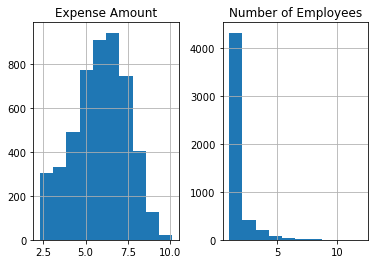

In [3]:
df.dtypes
df[['Expense Amount','Number of Employees']].hist()

#df[['Expense Amount','Number of Employees']].corr()

#### Train, test values

In [4]:
#Breaking the data and selecting features , predictors
predictors=df.drop(['Expense Amount','Date'],axis=1)
target=df['Expense Amount']
x_train,x_cv,y_train,y_cv=train_test_split(predictors,target,test_size=0.2,random_state=42)

### Modelling

In [5]:
#Comparing Algorithms
def scores(i):
    lin = i()
    lin.fit(x_train, y_train)
    y_pred=lin.predict(x_cv)
    lin_r= r2_score(y_cv, y_pred)
    s.append(lin_r)
#Checking the scores by using our function
algos=[LinearRegression,KNeighborsRegressor,
       RandomForestRegressor,Lasso,ElasticNet,DecisionTreeRegressor]
s=[]
for i in algos:
    scores(i)

models = pd.DataFrame({
    'Method': ['LinearRegression', 'KNeighborsRegressor',
               'RandomForestRegressor', 'Lasso','DecisionTreeRegressor'],
    'Score': [s[0],s[1],s[2],s[3],s[4]]})
models.sort_values(by='Score', ascending=False)

,Method,Score
2,RandomForestRegressor,0.572231
0,LinearRegression,0.435197
1,KNeighborsRegressor,0.142034
4,DecisionTreeRegressor,0.089588
3,Lasso,0.001440


#### Random Forest

In [6]:
predictionsDict = {}
model = RandomForestRegressor()
model.fit(x_train,y_train)
y_pred = model.predict(x_cv)
predictionsDict['RandomForest'] = y_pred
r2_score(y_cv,y_pred)

0.5659525995861516

#### XGBoost

In [7]:
#reg = xgb.XGBRegressor(subsample = 0.7, n_estimators = 500, max_depth = 6, learning_rate = 0.01, colsample_bytree = 0.6, colsample_bylevel = 0.8)
reg = xgb.XGBRegressor()

reg.fit(x_train, y_train,
        verbose=False, early_stopping_rounds=15,eval_set=[(x_cv,y_cv)])  # Change verbose to True if you want to see it train
y_pred = reg.predict(x_cv)
predictionsDict['XGBoost'] = y_pred
r2_score(y_cv,y_pred)

/opt/homebrew/Caskroom/miniforge/base/envs/python38/lib/python3.8/site-packages/xgboost/data.py:262: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  elif isinstance(data.columns, (pd.Int64Index, pd.RangeIndex)):


0.5438569617277086

##### XGBoost Tuner

In [ ]:
params = { 'max_depth': [3, 5, 6, 10, 15, 20],
           'learning_rate': [0.01, 0.1, 0.2, 0.3],
           'subsample': np.arange(0.5, 1.0, 0.1),
           'colsample_bytree': np.arange(0.4, 1.0, 0.1),
           'colsample_bylevel': np.arange(0.4, 1.0, 0.1),
           'n_estimators': [100, 500, 1000]}
xgbr = xgb.XGBRegressor(seed = 20)
clf = RandomizedSearchCV(estimator=xgbr,
                         param_distributions=params,
                         scoring='neg_mean_squared_error',
                         n_iter=25,
                         verbose=1)
clf.fit(x_train, y_train)
print("Best parameters:", clf.best_params_)
print("Lowest RMSE: ", (-clf.best_score_)**(1/2.0))

#### LightGBM

In [8]:
lightGBM = lgb.LGBMRegressor()
lightGBM.fit(x_train, y_train)
y_pred = lightGBM.predict(x_cv)
predictionsDict['Lightgbm'] = y_pred
r2_score(y_cv, y_pred)

0.5322585575717722

#### Compare model residuals

In [9]:
#compare models
models = ['RandomForest',
          'Lightgbm',
          'XGBoost']
resis = pd.DataFrame(data={k: y_cv -
                              v for k, v in predictionsDict.items()})[models]
corr = resis.corr()
print("Residuals correlation")
corr.style.background_gradient(cmap='coolwarm')

Residuals correlation


,RandomForest,Lightgbm,XGBoost
RandomForest,1.000000,0.918724,0.910894
Lightgbm,0.918724,1.000000,0.953920
XGBoost,0.910894,0.953920,1.000000


### Final prediction

In [18]:
split_date = pd.datetime(2020,12,1)

raw = pd.read_excel("expenses.xlsx",sheet_name='Sheet 1')
raw['Date'] = pd.to_datetime(raw['Date'], format="%d.%m.%Y")
raw = raw.loc[raw['Date'] >= split_date]

df_training = df.loc[df['Date'] < split_date]
df_future = df.loc[df['Date'] >= split_date]

predictors = df_training.drop(['Expense Amount','Date'],axis=1)
target = df_training['Expense Amount']
model.fit(predictors, target)

future = df_future.drop(['Expense Amount','Date'],axis=1)
raw['Predicted Expense Amount'] = np.exp(model.predict(future))
raw.drop('Expense Amount',axis=1,inplace=True)
raw.to_csv('future-expenses.csv',index=False)
raw

# export = pd.concat([df, future])
# with pd.ExcelWriter("~/Downloads/calls.xlsx", engine="openpyxl", mode="a", if_sheet_exists="replace") as writer:
#     export.to_excel(writer, 'Future', index=False)

/var/folders/4z/q2mxf7h14d7d2xg4_lsrtjcc0000gn/T/ipykernel_1584/2170093112.py:1: FutureWarning: The pandas.datetime class is deprecated and will be removed from pandas in a future version. Import from datetime module instead.
  split_date = pd.datetime(2020,12,1)


,Date,Department,Expense Type,Billable Flag,Number of Employees,Predicted Expense Amount
4872,2020-12-01,Engineering,Meals,N,1,172.016695
4873,2020-12-01,Engineering,Miscellaneous,N,1,71.284064
4874,2020-12-01,Engineering,Operations,N,1,726.452589
4875,2020-12-01,Engineering,Travel,N,1,468.382260
4876,2020-12-01,Support,Meals,N,1,76.461765
...,...,...,...,...,...,...
5062,2020-12-30,Sales,Operations,N,2,445.364876
5063,2020-12-30,Sales,Travel,N,3,3364.930284
5064,2020-12-30,Support,Operations,N,1,125.183912
5065,2020-12-30,Support,Travel,N,2,2135.552803
